# Color Classification


## **Load** **Data**

In [ ]:
import cv2
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/train_dataset.csv')

In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/test_dataset.csv')

In [ ]:
train_data

id  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
0      10003      255      255      255      255      255      255      255   
1      10004      255      255      255      254      254      254      255   
2      10005      255      253      255      252      251      253      255   
3      10006      255      255      255      254      254      254      255   
4      10007      255      255      254      255      255      254      255   
...      ...      ...      ...      ...      ...      ...      ...      ...   
21225   9992      255      255      255      255      255      255      255   
21226   9996      255      255      249      255      255      252      255   
21227   9997      255      255      254      255      255      254      252   
21228   9998      250      255      254      250      255      254      253   
21229   9999      251      255      254      253      255      254      254   

       pixel_7  pixel_8  ...  pixel_2616  pixel_2617  pixel_2618  pixel_2619  \
0          255      255  ...         254         254         254         255   
1          255      255  ...         255         255         255         255   
2          255      252  ...         248         253         255         250   
3          255      255  ...         254         254         254         255   
4          255      255  ...         253         253         253         254   
...        ...      ...  ...         ...         ...         ...         ...   
21225      255      255  ...         250         255         253         253   
21226      253      255  ...         255         255         255         255   
21227      255      253  ...         255         255         255         255   
21228      255      254  ...         255         255         255         255   
21229      255      253  ...         255         255         255         255   

       pixel_2620  pixel_2621  pixel_2622  pixel_2623  pixel_2624  baseColour  
0             255         255         254         254         254           6  
1             255         255         255         255         255           3  
2             254         255         255         255         252           1  
3             255         255         255         255         255           2  
4             254         254         255         255         254           6  
...           ...         ...         ...         ...         ...         ...  
21225         255         255         255         254         255           0  
21226         255         255         255         255         255           1  
21227         255         255         255         255         255           1  
21228         255         255         255         255         255           8  
21229         255         255         255         255         255           1  

[21230 rows x 2627 columns]

## Preprocces

In [ ]:
class_counts = train_data['baseColour'].value_counts()

In [ ]:
color_800 = class_counts[class_counts >= 800].index
train_data= train_data[train_data['baseColour'].isin(color_800)]

In [ ]:
class_counts = train_data['baseColour'].value_counts()

In [ ]:
class_counts

2     4383
6     3110
1     2911
3     1521
7     1445
10    1296
4     1246
0     1056
8      808
5      808
Name: baseColour, dtype: int64

In [ ]:
classes = [2, 6, 1, 3, 7, 10, 4, 0, 8, 5]

test_data = test_data[test_data['baseColour'].isin(classes)]

In [ ]:
classes = [2, 6, 1, 3, 7, 10, 4, 0, 8, 5]
new_classes = {original: new_no for new_no, original in enumerate(classes)}

train_data['baseColour'] = train_data['baseColour'].map(new_classes)
test_data['baseColour'] = test_data['baseColour'].map(new_classes)

<ipython-input-11-e06773e32a53>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['baseColour'] = train_data['baseColour'].map(new_classes)


In [ ]:
class_counts = train_data['baseColour'].value_counts()
class_counts

0    4383
1    3110
2    2911
3    1521
4    1445
5    1296
6    1246
7    1056
8     808
9     808
Name: baseColour, dtype: int64

In [ ]:
train = train_data.drop('id', axis=1)
test = test_data.drop('id', axis=1)

In [ ]:
X_train = train.iloc[:, :-1].values
Y_train = train.iloc[:, -1].values

In [ ]:
Y_train = np.array(Y_train)

In [ ]:
X_test = test.iloc[:, :-1].values
Y_test = test.iloc[:, -1].values

In [ ]:
X_train = X_train.reshape(-1, 35, 25, 3)
X_test = X_test.reshape(-1, 35, 25, 3)

### Data augmentation

In [ ]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
)

augmented_images = []
augmented_labels = []

for img, label in zip(X_train, Y_train):
    img = img.reshape((1,) + img.shape)
    label = np.array([label])

    for x_batch, y_batch in datagen.flow(img, label, batch_size=3):
        augmented_images.append(x_batch[0])
        augmented_labels.append(y_batch[0])
        break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [ ]:
X_train = np.concatenate((X_train, augmented_images), axis=0)
Y_train = np.concatenate((Y_train, augmented_labels), axis=0)

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
Y_train_one_hot = to_categorical(Y_train, 10)
Y_test_one_hot = to_categorical(Y_test, 10)

### Penalty

Applying a penalty to minority classes helps the model focus on them, improving generalization even with a imbalanced dataset.

In [ ]:
#class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)

In [ ]:
#class_weight_dict = dict(zip(np.unique(Y_train), class_weights))

## CNN


### Model

In this section different architectures were trained, this was in order to get better models


In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(35, 25, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(35, 25, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(35, 25, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(35, 25, 3)),

    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),


    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from keras.optimizers import RMSprop


model = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(35, 25, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(35, 25, 3)),

    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax'),
])

#model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=RMSprop(learning_rate=0.001, rho=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(35, 25, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(35, 25, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Training

In [ ]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 32, validation_data=(X_test, Y_test))

In [ ]:
model.fit(X_train, Y_train, epochs = 30, batch_size = 64, validation_data=(X_test, Y_test), class_weight = class_weight_dict)

### Evaluation

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test_one_hot)
print(f'Test accuracy: {test_accuracy}')

### Save model

In [ ]:
from keras.models import load_model
model.save('10colores_nopooling.h5')
#model = load_model('10colores_73accuracy.h5')


In [ ]:
model.summary()

# Apparel classification


## Load data

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/fashion-mnist_train.csv')

In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/fashion-mnist_test.csv')

## Get features and labels

In [ ]:
y_train = train_data.iloc[:, 0]
X_train = train_data.iloc[:, 1:]

y_test = test_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]

X_train = X_train.values / 255.0
X_test = X_test.values / 255.0

In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

## CNN

### Model

In this section different architectures were trained, this was in order to get better models

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.5),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.5),
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),

    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training

In [ ]:
model.fit(X_train, y_train, epochs = 10, batch_size = 64, validation_data=(X_test, y_test))

### Validation

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

In [ ]:
model.save('Apparel.h5')
#model = load_model('10colores_73accuracy.h5')


# Implementation


The different models were implemented using new images (different from test and train data) and finally was chosen the one with the best performance.


In [ ]:
model_color = load_model('10colores_73accuracy.h5')

In [ ]:
model_color.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 23, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 33, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 33, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 21, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 21, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 19, 32)        9

In [ ]:
model_apparel = load_model('Apparel.h5')

In [ ]:
model_apparel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0

In [ ]:
def Detection(img, colorModel, deteccionModel):
  imagen = cv2.imread(img)
  img_color = imagen

  shape_original = imagen.shape
  cut = 0.08

  blur = cv2.GaussianBlur(imagen, (31, 31), 0)

  recorte_horizontal = int(shape_original[1] * cut)
  recorte_vertical = int(shape_original[0] * cut)

  imagen_recortada = blur[recorte_vertical:-recorte_vertical, recorte_horizontal:-recorte_horizontal]

  imagen_color = cv2.resize(imagen_recortada, (25, 35))

  imagen_gris = cv2.resize(cv2.cvtColor(imagen_recortada, cv2.COLOR_BGR2GRAY), (28, 28))
  imagen_gris = cv2.bitwise_not(imagen_gris)

  imagen_gris = imagen_gris.reshape((1, 28, 28, 1))
  imagen_gris = imagen_gris/ 255.0

  imagen_color = imagen_color.reshape((1, 35, 25, 3))
  imagen_color = imagen_color/ 255.0

  prediccion_color = colorModel.predict(imagen_color)
  prediccion_color = np.round(prediccion_color)

  label_mapping = {
      0: "Black",
      1: "White",
      2: "Blue",
      3: "Grey",
      4: "Brown",
      5: "Red",
      6: "Green",
      7: "Navy Blue",
      8: "Pink",
      9: "Purple"
  }

  indice_prediccion = np.argmax(prediccion_color)

  color = label_mapping[indice_prediccion]

  prediccion_prenda = deteccionModel.predict(imagen_gris)
  prediccion_prenda = np.round(prediccion_prenda)

  label_mapping = {
      0: "T-shirt/top",
      1: "Trouser",
      2: "Pullover",
      3: "Dress",
      4: "Coat",
      5: "Sandal",
      6: "Shirt",
      7: "Sneaker",
      8: "Bag",
      9: "Ankle boot"
  }

  indice_prediccion = np.argmax(prediccion_prenda)
  apparel = label_mapping[indice_prediccion]

  plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
  plt.title(f'Detection: A {color} {apparel}')
  plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 111ms/step


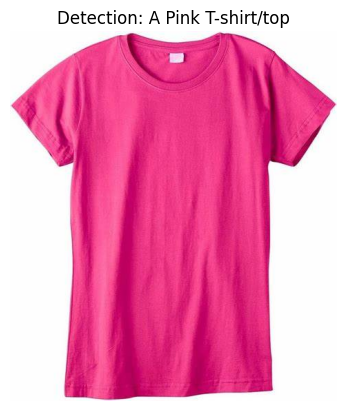

In [ ]:
Detection('Pink.jpg', model_color, model_apparel)

1/1 [==============================] - 0s 28ms/step


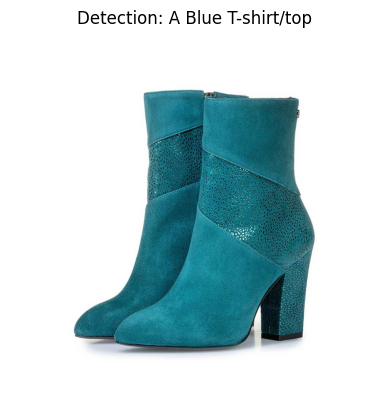

In [ ]:
Detection('boot.jpg', model_color, model_apparel)

1/1 [==============================] - 0s 38ms/step


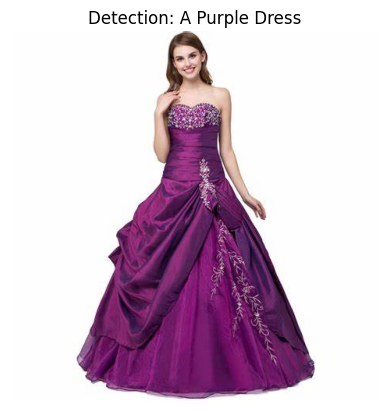

In [ ]:
Detection('Purple.jpg', model_color, model_apparel)

1/1 [==============================] - 0s 31ms/step


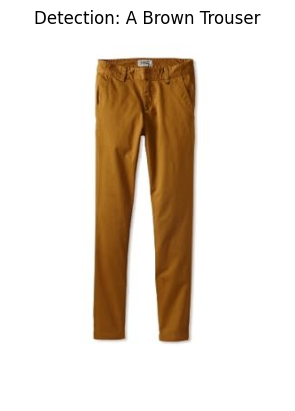

In [ ]:
Detection('Brown.jpg', model_color, model_apparel)

1/1 [==============================] - 0s 24ms/step


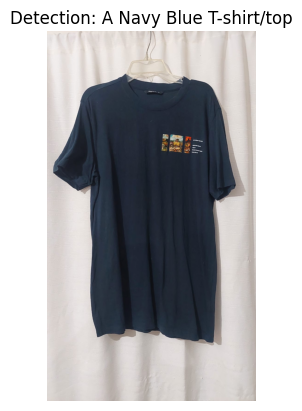

In [ ]:
Detection('XD.jpeg', model_color, model_apparel)

1/1 [==============================] - 0s 23ms/step


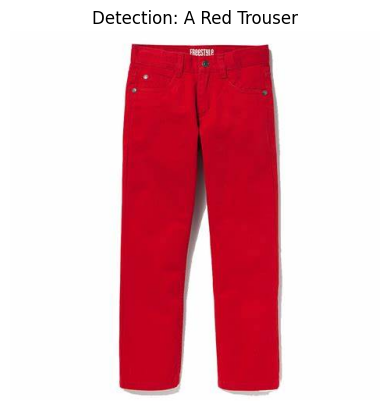

In [ ]:
Detection('Red.jpg', model_color, model_apparel)

1/1 [==============================] - 0s 26ms/step


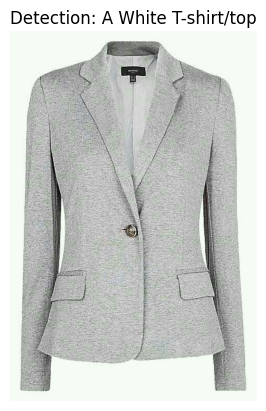

In [ ]:
Detection('grey.jpg', model_color, model_apparel)

1/1 [==============================] - 0s 26ms/step


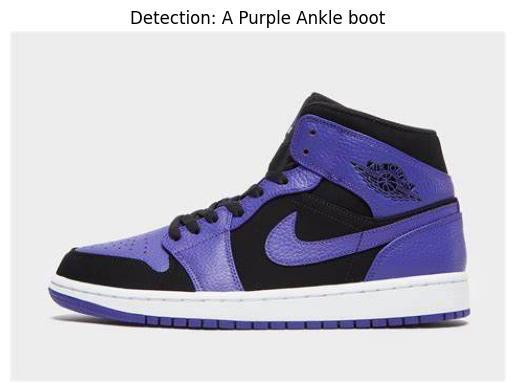

In [ ]:
Detection('sneaker.jpg', model_color, model_apparel)

# Unsupervised



In this section, the objective is to identify clusters of images that share similarities. This is intended to be incorporated into future reinforcement learning, where rewards can be applied to similar clothing items as part of the learning process.

To generate these clusters, Principal Component Analysis (PCA) was employed. PCA is a dimensionality reduction technique that transforms the original features into a new set of orthogonal components, capturing the variance in the data. These components were then used in conjunction with K-means clustering, that is an unsupervised machine learning algorithm that partitions data points into k clusters based on their similarity.

In [ ]:
!pip install plotly

In [ ]:
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

In [ ]:
X_train_reshaped = X_train.reshape((37168, -1))

## Training


In [ ]:
# PCA
n_components = 3
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_reshaped)

# K-Means with 3 clusters
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(X_train_pca)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## PCA

Three principal components were used for the purpose of visualizing them in a three-dimensional space.

In [ ]:
# Crea un DataFrame para Plotly Express
df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Agrega una columna para representar el color (por ejemplo, usando la primera componente principal)
df['color'] = df['PC1']

# Crea una figura interactiva con Plotly Express
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='color', opacity=0.7, title='PCA Visualization')

# Muestra la figura interactiva
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Clustering

In this part, we aimed to display some images within each created cluster.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



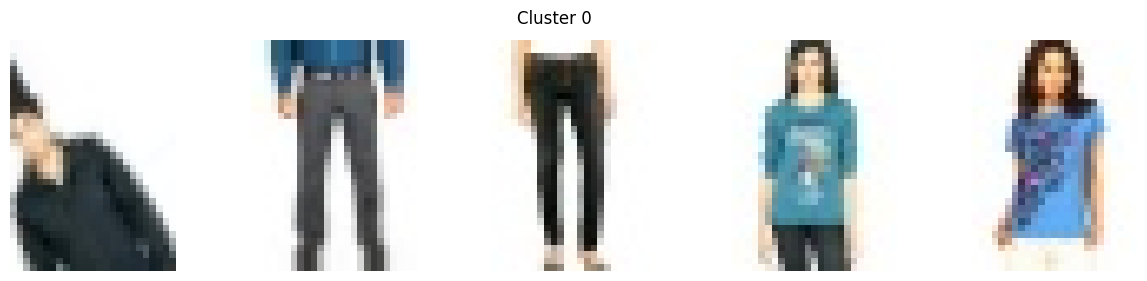

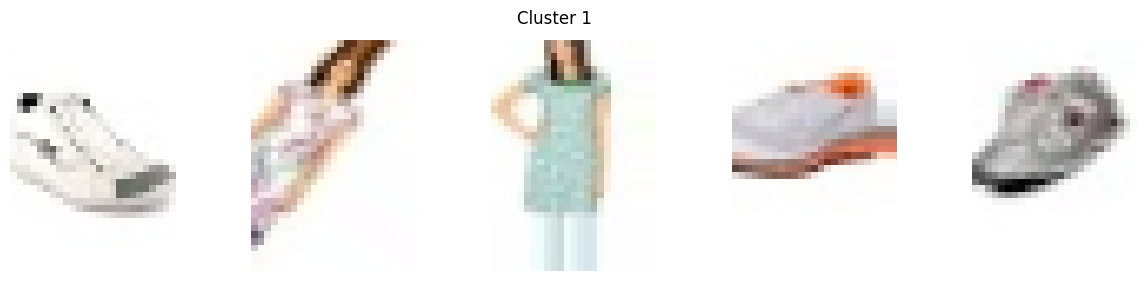

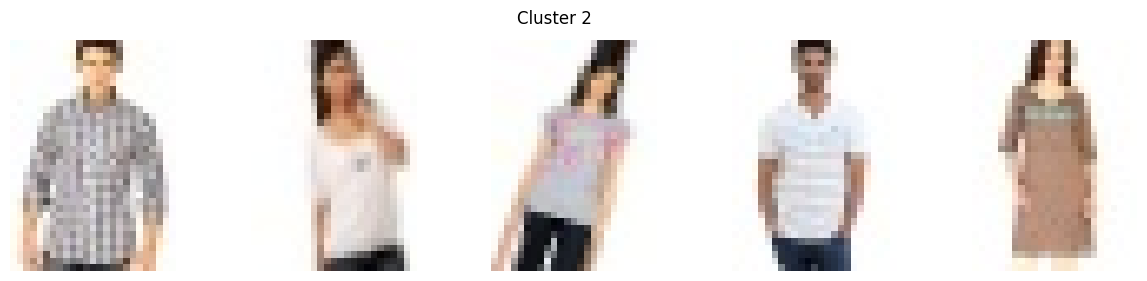

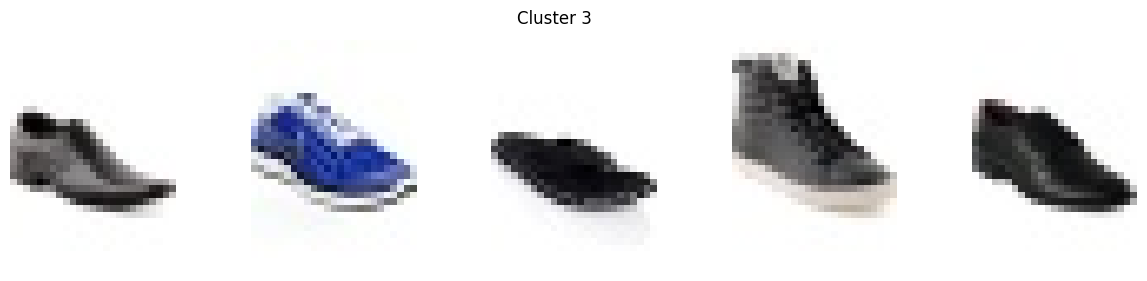

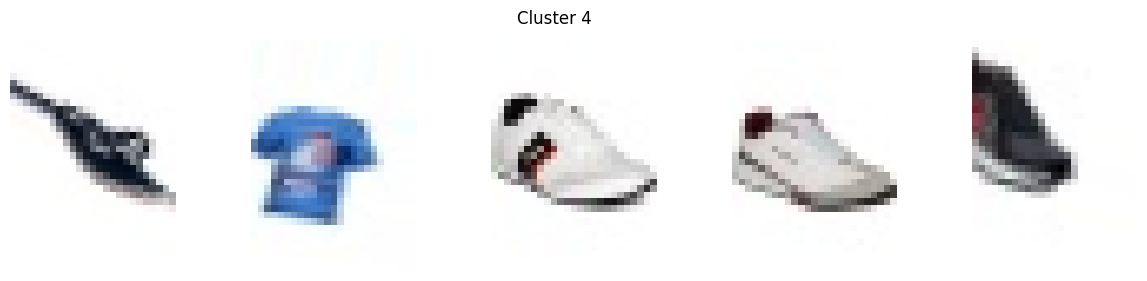

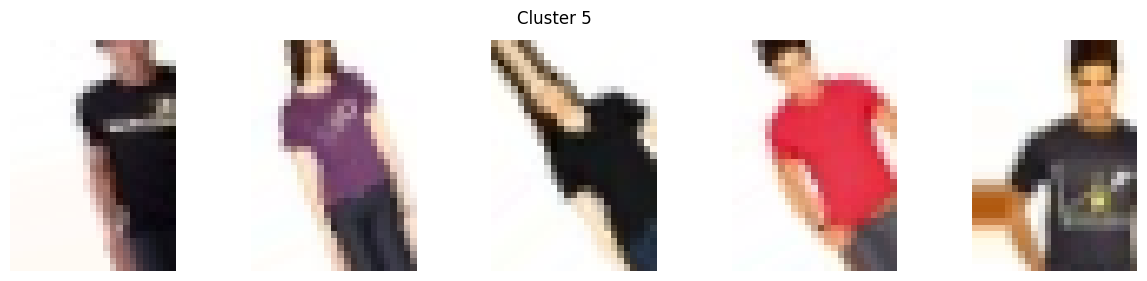

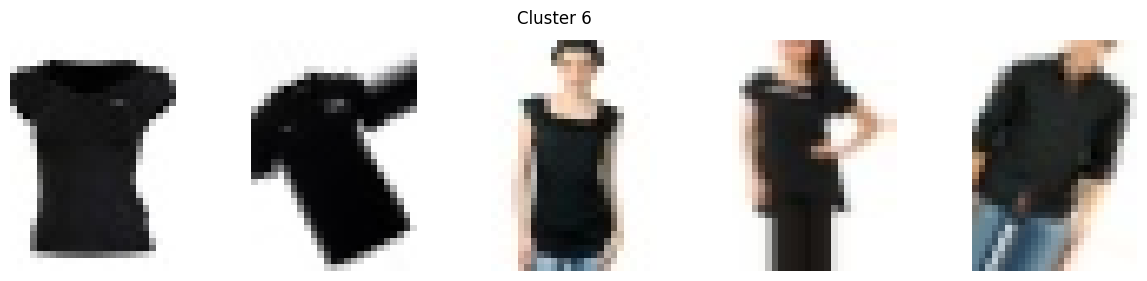

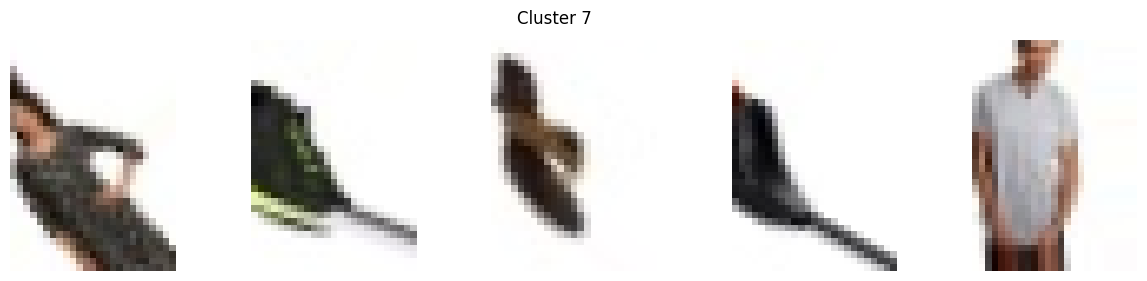

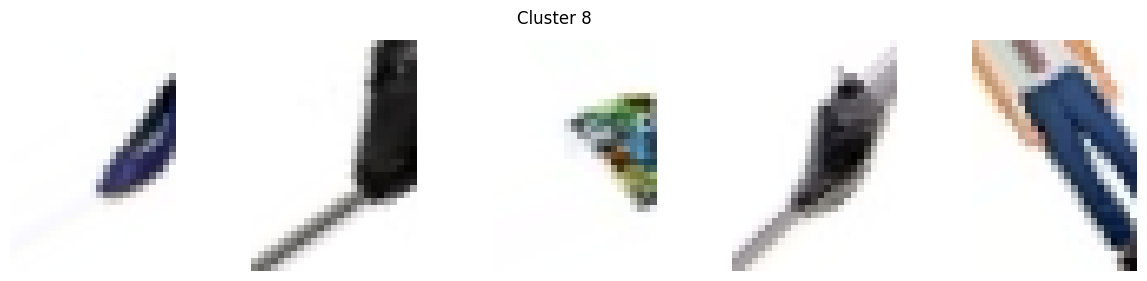

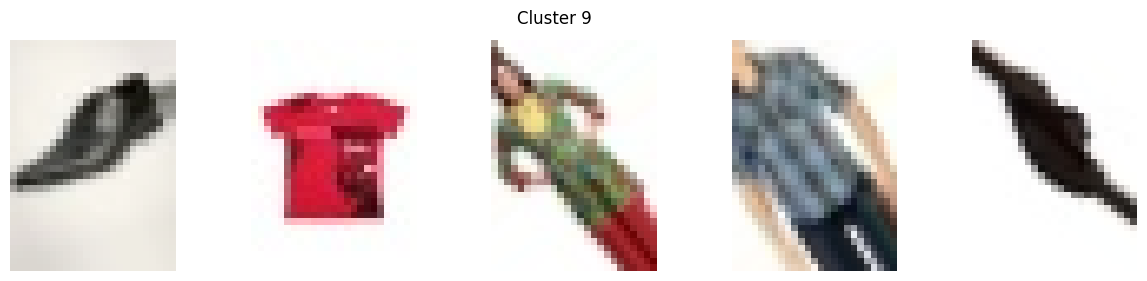

In [ ]:
cluster_indices = [[] for _ in range(n_clusters)]
for i, label in enumerate(labels):
    cluster_indices[label].append(i)

num_images_per_cluster = 5

for cluster in range(n_clusters):
    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Cluster {cluster}')

    for i in range(num_images_per_cluster):
        random_index = np.random.choice(cluster_indices[cluster])
        original_image_bgr = X_train[random_index]
        original_image_bgr = cv2.normalize(original_image_bgr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        original_image_rgb = cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images_per_cluster, i + 1)
        plt.imshow(original_image_rgb)
        plt.axis('off')

    plt.show()


# Reinforcement Learning

Regarding reinforcement learning, currently, the model learns to create outfits by considering the upper part, lower part, and footwear, along with color groups and the cluster to which they belong.

In this initial approach, color groups were directly chosen; ideally, this should be done through unsupervised learning. Similarly, for clusters, like colors, they were labeled from 1 to 10, which should also be determined through unsupervised learning.

That being said, the model is trained, and rewards are provided if the chosen garment is correctly positioned, if the colors of each garment are from the same color group, and if the clusters are the same or close (e.g., 1 is close to 2 but distant from 10).

In [ ]:
import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete
import numpy as np
import random
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle



In [ ]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

In [ ]:
pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 25.6 MB/s eta 0:00:00


In [ ]:
pip install --upgrade stable-baselines3

In [ ]:
pip install -U stable-baselines3


In [ ]:
!pip install 'shimmy>=0.2.1'

## Enviroment

In [ ]:
import gym
from gym import spaces
from gym.spaces import Box, Dict
import numpy as np
import pandas as pd
from gym.spaces import MultiDiscrete


class FashionEnv(gym.Env):
    def __init__(self):

        # Define Action
        self.action_space = MultiDiscrete([10, 10, 10, 10, 10, 10, 10, 10, 10])  # 9x1 for clothing, color, and cluster

        # Define Observation space
        self.observation_space = MultiDiscrete([11, 11, 11, 11, 11, 11, 11, 11, 11])   # 9x1 for clothing, color, and cluster

    def step(self, action):

        epsilon = 0.3

        # Exploration strategy: epsilon-greedy
        if np.random.rand() < epsilon:
            action = self.action_space.sample()
        else:
            pass

        self.state = action

        top_labels = [0, 2, 4, 6]         # T-shirt/top, Pullover, Coat, Shirt
        bottom_labels = [1]               # Trouser
        footwear_labels = [5, 7, 9]       # Sandal, Sneaker, Ankle boot
        others_labels = [3, 8]            # Dress, Bag


        group_color_1 = [5, 8, 0, 1]      # Red and Pink
        group_color_2 = [3, 4, 0, 1]      # Grey and Brown
        group_color_3 = [7, 2, 6, 0, 1]   # Navy Blue, Blue, Green
        group_color_4 = [9, 8, 2, 0, 1]   # Purple, Pink, and Blue

        reward = 0


        #Rewards if appareal well positionated
        if self.state[0] in top_labels:
          reward += 2

        elif self.state[0] not in top_labels:
          reward -= 2

        if self.state[1] in bottom_labels:
          reward += 2

        elif self.state[1] not in bottom_labels:
          reward -= 2

        if self.state[2] in footwear_labels:
          reward += 2

        elif self.state[2] not in footwear_labels:
          reward -= 2


        #Rewards if more than one color chosen belong to the same group
        if sum(item in group_color_1 for item in self.state[3:6]) >= 2:
            reward += 2 if all(item in group_color_1 for item in self.state[3:6]) else 1

        elif sum(item in group_color_2 for item in self.state[3:6]) >= 2:
            reward += 2 if all(item in group_color_2 for item in self.state[3:6]) else 1

        elif sum(item in group_color_3 for item in self.state[3:6]) >= 2:
            reward += 2 if all(item in group_color_3 for item in self.state[3:6]) else 1

        elif sum(item in group_color_4 for item in self.state[3:6]) >= 2:
            reward += 2 if all(item in group_color_4 for item in self.state[3:6]) else 1
        else:
            reward -= 1

        # Rewards if the clusters are the same or at least two are the same
        if self.state[6] == self.state[7] == self.state[8] or self.state[6] == self.state[7] or self.state[8] or self.state[6]:
            reward += 3
        if ((abs(self.state[6] - self.state[7])) > 5):
            reward -= 1
        if (abs(self.state[7] - self.state[8]) > 5):
            reward -= 1


        done = self.state is not None

        return self.state, reward, done, {}

    def render(self, state):
      # Show the outfit chosen according to the action
      lista_imagenes = ["t-shirt.jpg", "trouser.jpg", "pullover.jpg", "dress.jpg", "coat.jpg", "sandals.jpg", "shirt.jpg", "sneakers.jpg", "bag.jpg", "ankle.jpg"]

      colors_rgb_list = [
          (0, 0, 0),    # Black
          (0, 0, 255),  # Blue
          (255, 192, 203),  # Pink
          (128, 128, 128),  # Grey
          (0, 128, 0),  # Green
          (255, 0, 0),  # Red
          (128, 0, 128),  # Purple
          (255, 255, 255),  # Whites
          (111, 78, 55),  # Brown
          (0, 0, 128)  # Navy Blue
      ]

      cluster = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

      prenda_1, prenda_2, prenda_3 = state[:3]
      color_1, color_2, color_3 = state[3:6]
      estilo_1, estilo_2, estilo_3 = state[6:]


      fig, axs = plt.subplots(3, 3, figsize=(10, 10))

      imagenes = [cv2.imread(lista_imagenes[prenda], cv2.IMREAD_GRAYSCALE) for prenda in [prenda_1, prenda_2, prenda_3]]
      for i, imagen in enumerate(imagenes):
          imagen = cv2.resize(imagen, (250, 250))
          imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

          axs[i, 0].imshow(imagen)
          axs[i, 0].axis('off')
          axs[i, 0].set_title('Apparel:')

      for i, color_index in enumerate([color_1, color_2, color_3]):
          color = colors_rgb_list[color_index]
          color_normalized = (color[0]/255, color[1]/255, color[2]/255)  # Normalizar el color al rango 0-1
          axs[i, 1].add_patch(Rectangle((0, 0), 1, 1, color=color_normalized))
          axs[i, 1].axis('off')
          axs[i, 1].set_title('Color:')

      for i, cluster_index in enumerate([estilo_1, estilo_2, estilo_3]):
          clusters = cluster[cluster_index]
          axs[i, 2].text(0.5, 0.5, clusters, ha='center', va='center', fontsize = 20)
          axs[i, 2].axis('off')  # Desactivar ejes
          axs[i, 2].set_title('Cluster:')

      plt.show()

    def reset(self):
        # Reset state
        self.state = [10, 10, 10, 10, 10, 10, 10, 10, 10]

        return self.state


## Enviroment test

In [ ]:
env = FashionEnv()

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning:

WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/



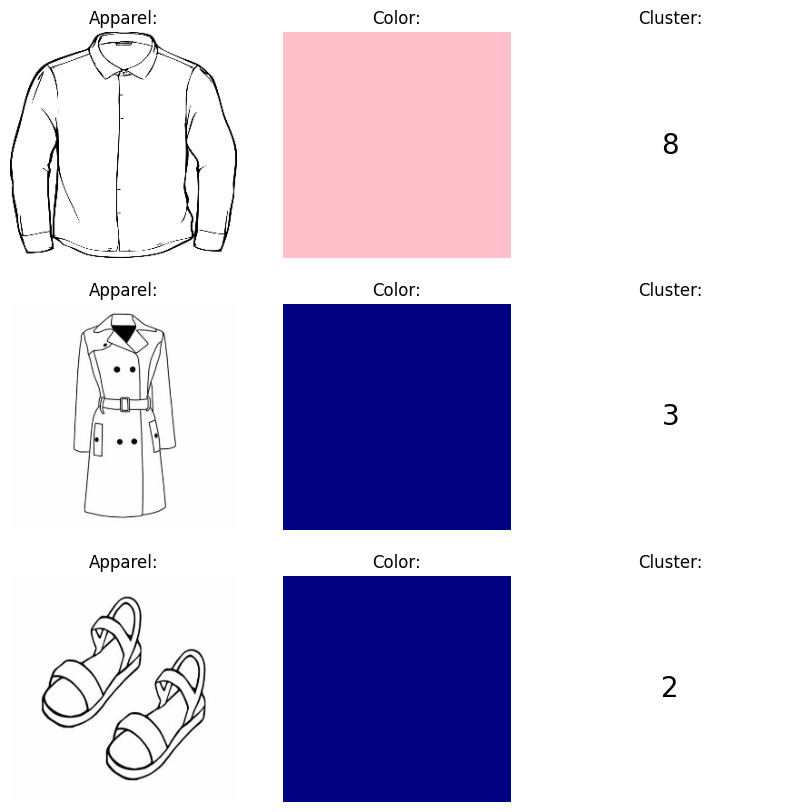

Episode:1 Score:7


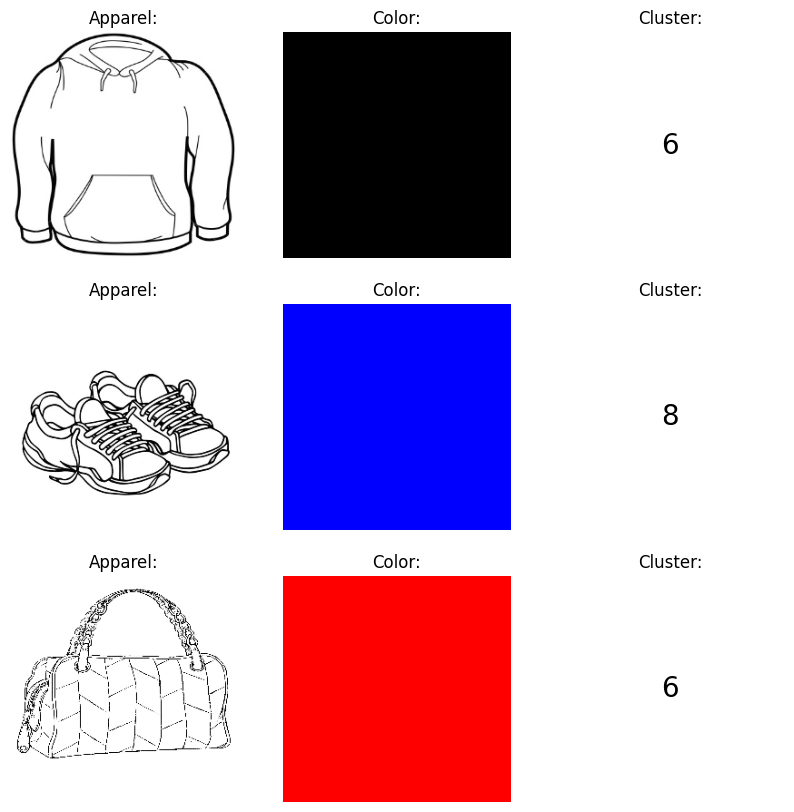

Episode:2 Score:3


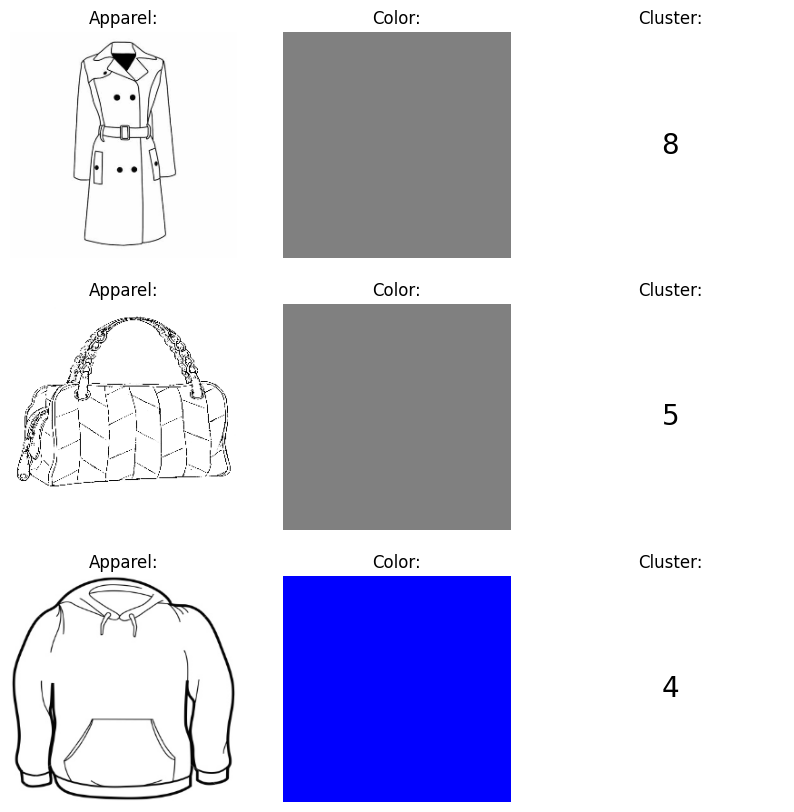

Episode:3 Score:3


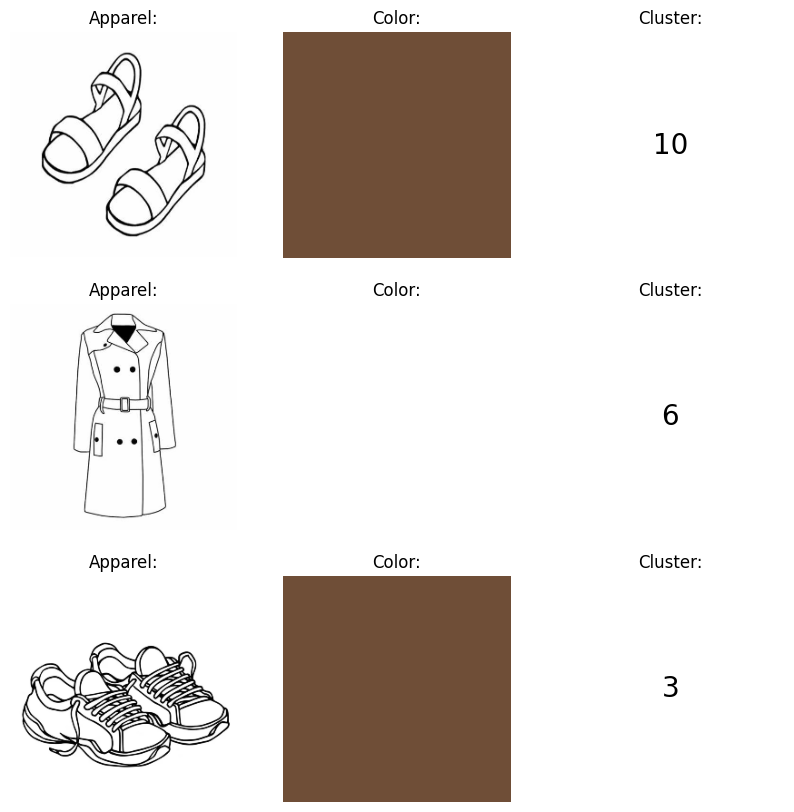

Episode:4 Score:2


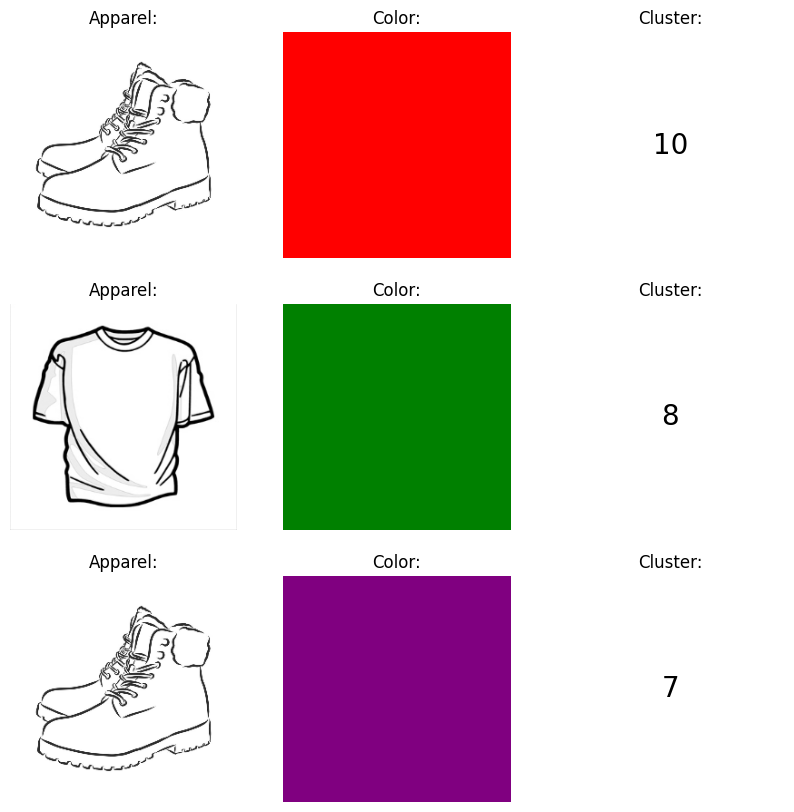

Episode:5 Score:0


In [ ]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        env.render(n_state)
        score += reward

    print('Episode:{} Score:{}'.format(episode, score))

env.close()


## Training

To train using the environment, PPO was utilized as the reinforcement learning algorithm, known for its effectiveness in optimizing policies. The specific policy architecture employed was "MlpPolicy," indicating the use of a Multi-Layer Perceptron (MLP), to define the agent's policy. PPO iteratively refines the policy to maximize rewards in the given environment, while MlpPolicy utilizes a multi-layered neural network for this purpose.

In [ ]:
env = FashionEnv()

In [ ]:
log_path = os.path.join('Training', 'Logs')
env = FashionEnv()

env = DummyVecEnv([lambda: env])

# Create PPO model and train
model = PPO("MlpPolicy", env, verbose = 1)
model.learn(total_timesteps = 300000)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



Using cpu device
-----------------------------
| time/              |      |
|    fps             | 82   |
|    iterations      | 1    |
|    time_elapsed    | 24   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 2           |
|    time_elapsed         | 40          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.028997436 |
|    clip_fraction        | 0.469       |
|    clip_range           | 0.2         |
|    entropy_loss         | -20.7       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 3.89        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0893     |
|    value_loss           | 10          |
-----------------------------------------
-----------------

## Model trained performance

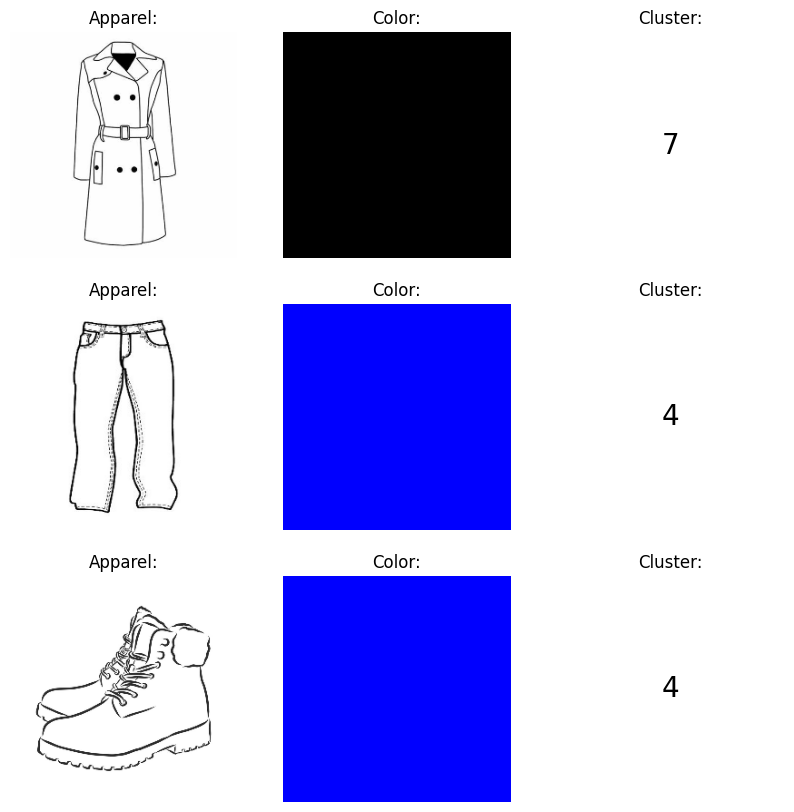

Outfit: [4 1 9 0 1 1 6 3 3], Reward: 11


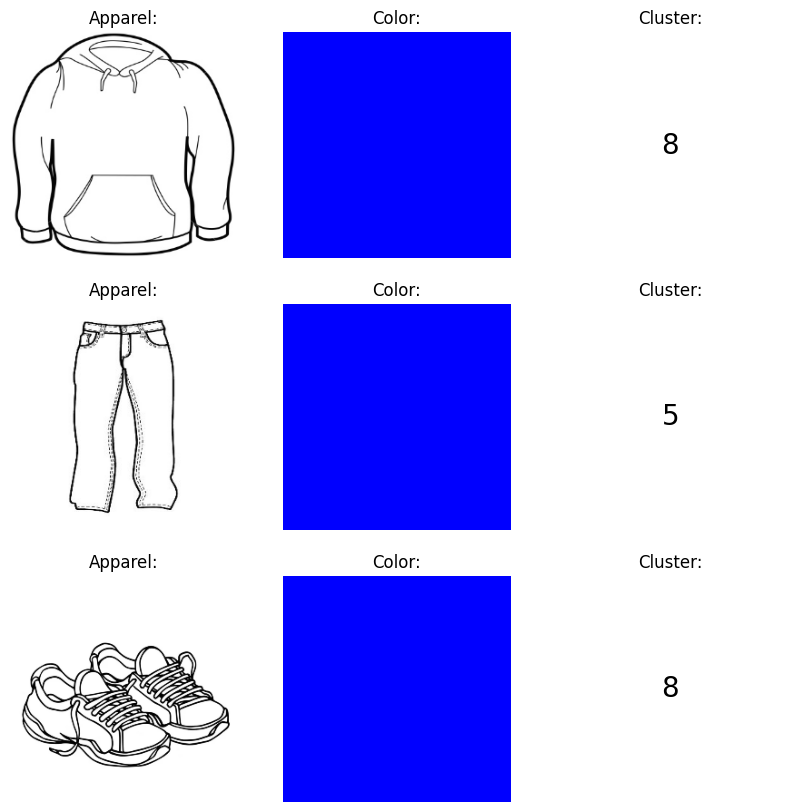

Outfit: [2 1 7 1 1 1 7 4 7], Reward: 11


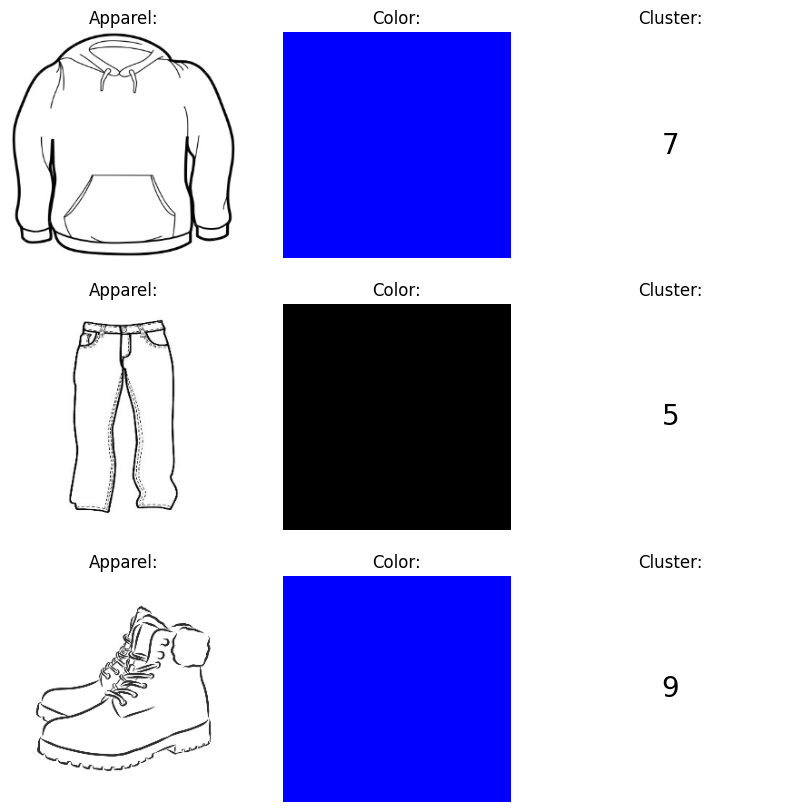

Outfit: [2 1 9 1 0 1 6 4 8], Reward: 11


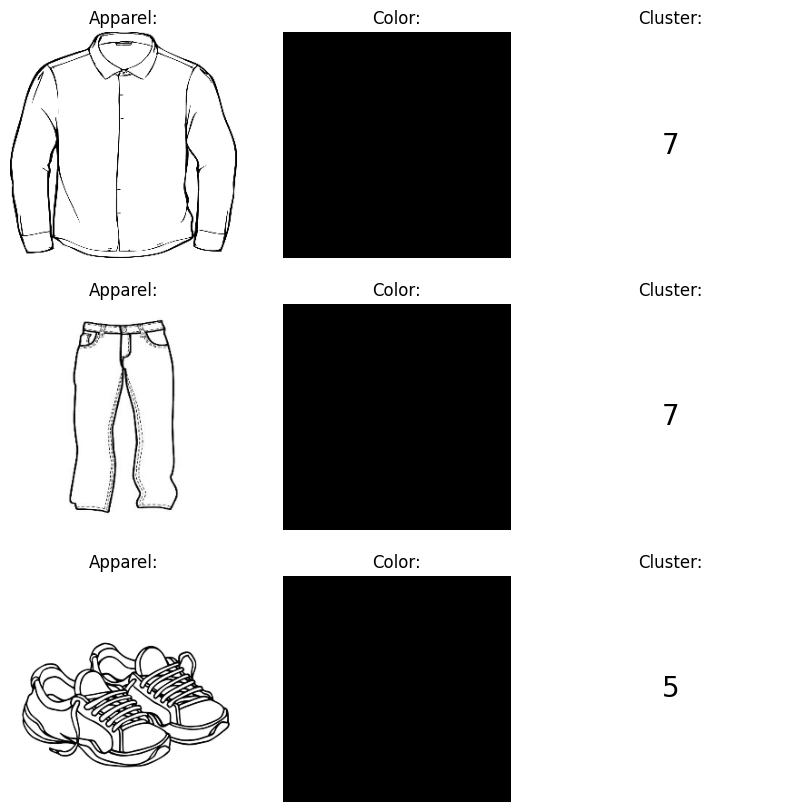

Outfit: [6 1 7 0 0 0 6 6 4], Reward: 11


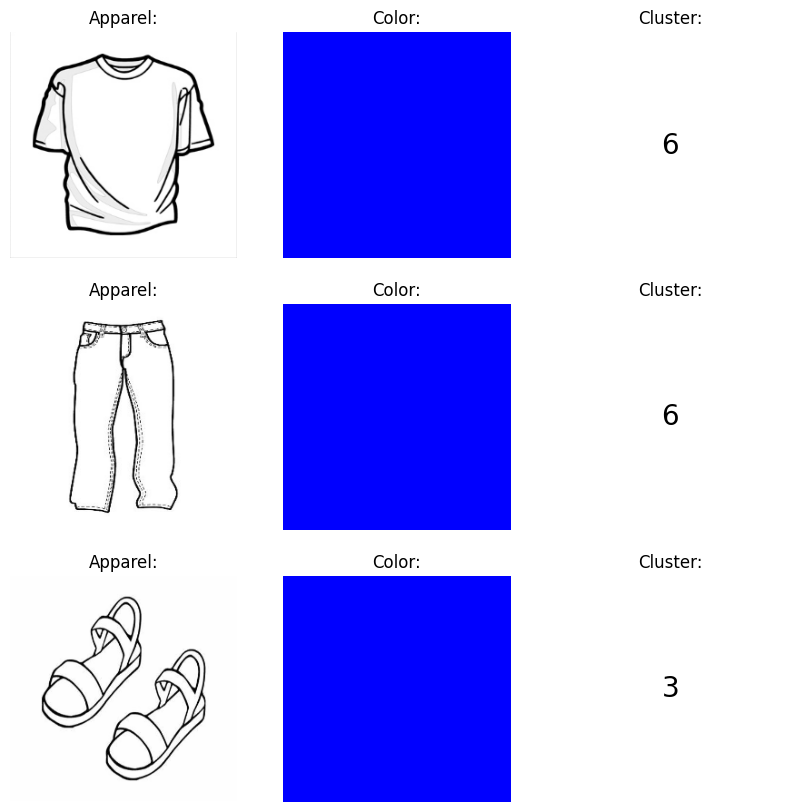

Outfit: [0 1 5 1 1 1 5 5 2], Reward: 11


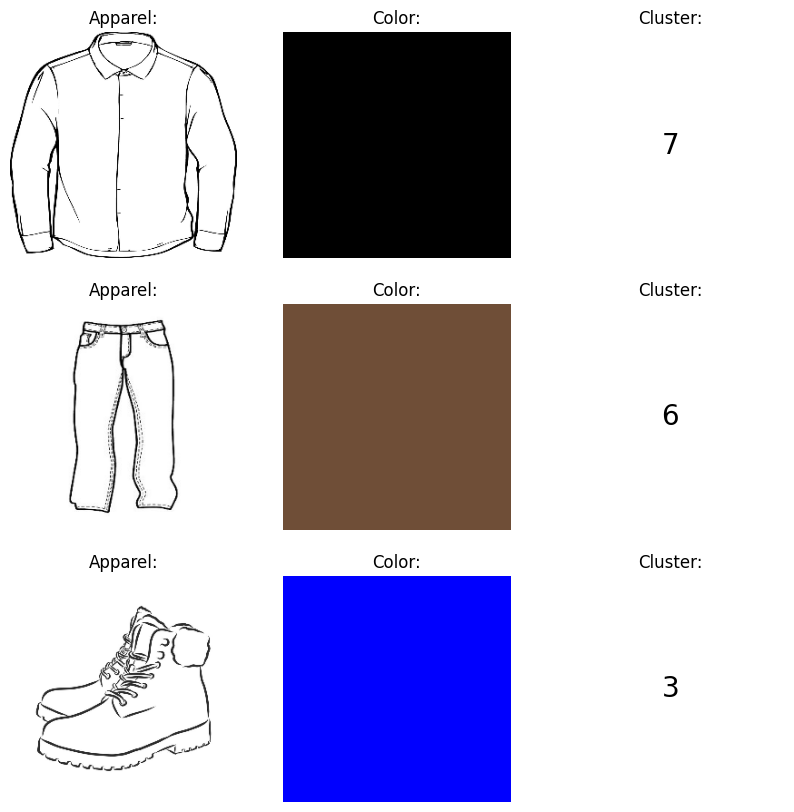

Outfit: [6 1 9 0 8 1 6 5 2], Reward: 11


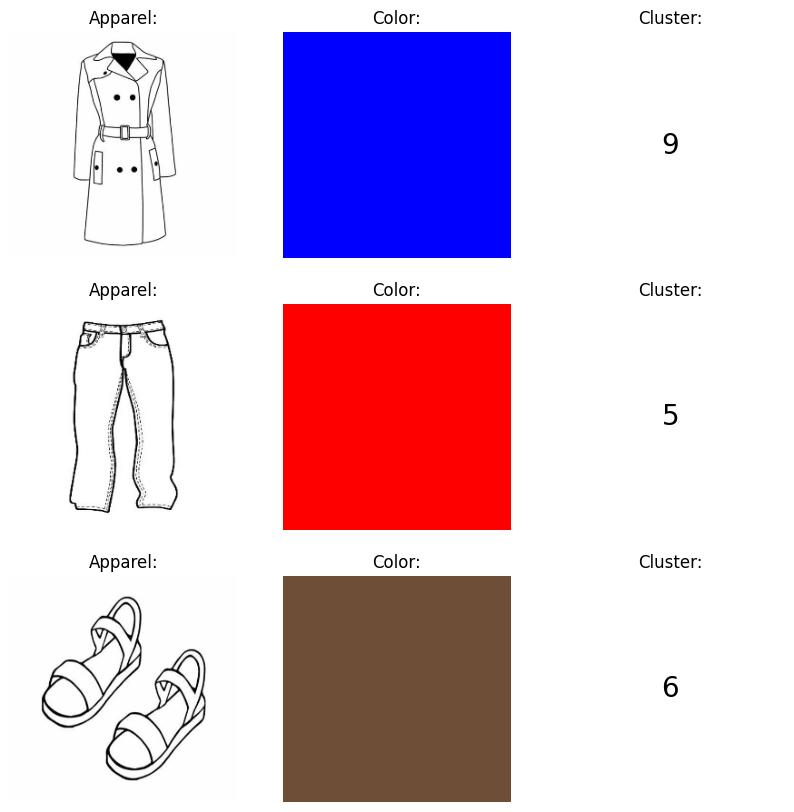

Outfit: [4 1 5 1 5 8 8 4 5], Reward: 7


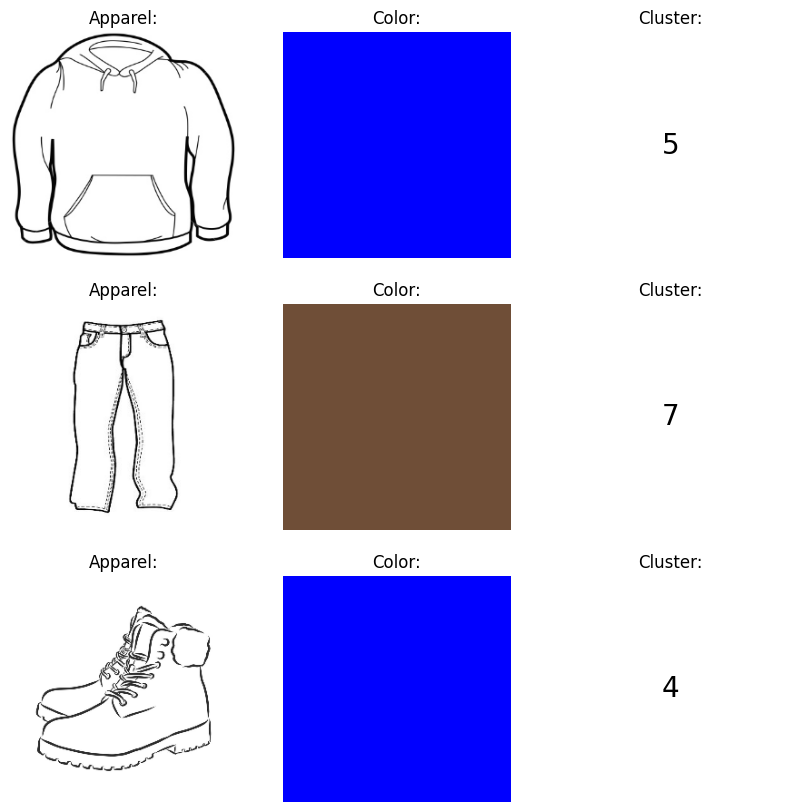

Outfit: [2 1 9 1 8 1 4 6 3], Reward: 11


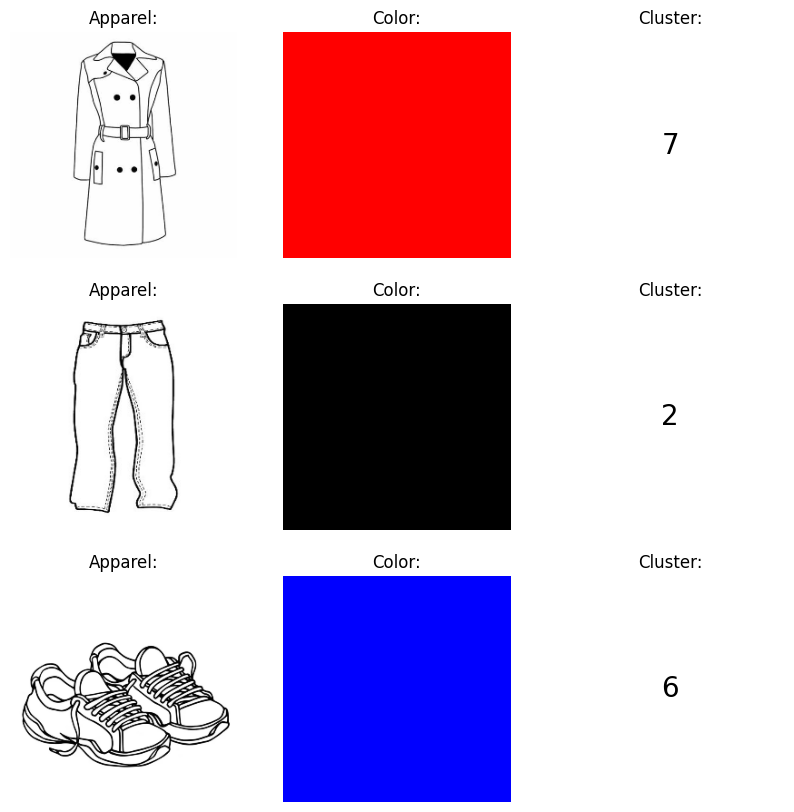

Outfit: [4 1 7 5 0 1 6 1 5], Reward: 11


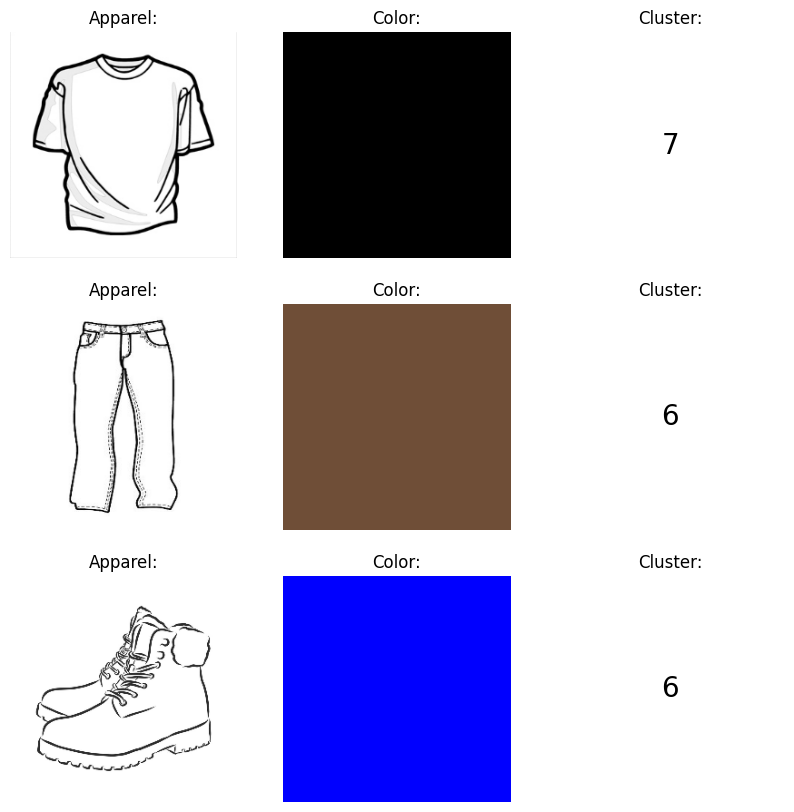

Outfit: [0 1 9 0 8 1 6 5 5], Reward: 11


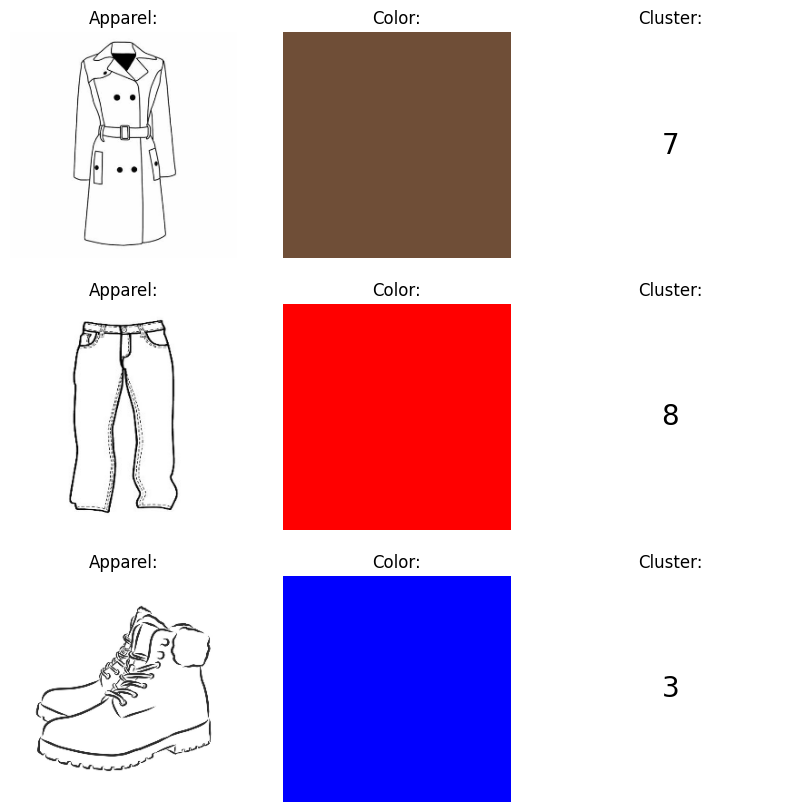

Outfit: [4 1 9 8 5 1 6 7 2], Reward: 11


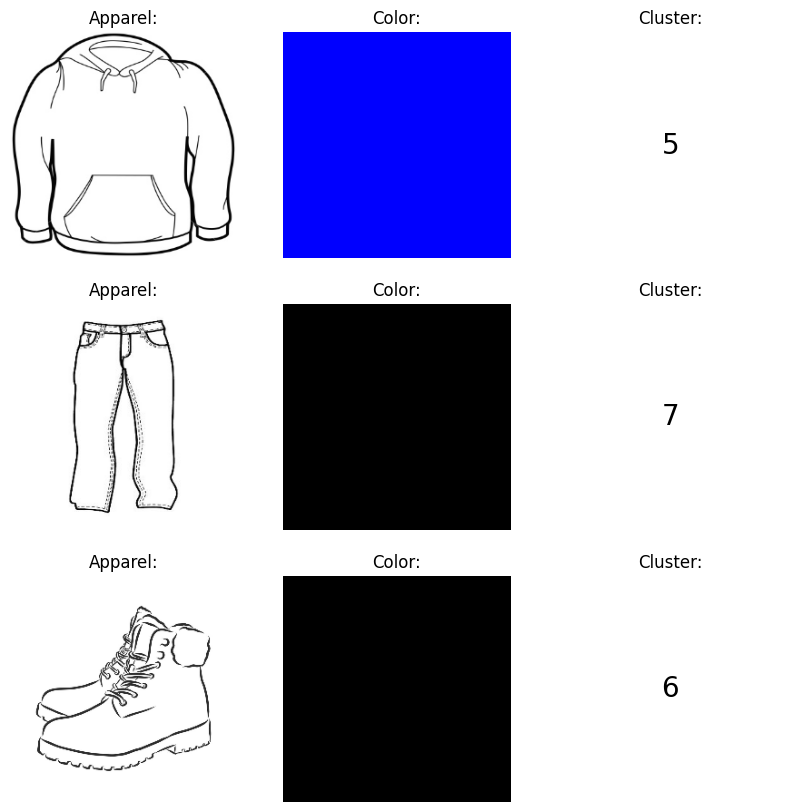

Outfit: [2 1 9 1 0 0 4 6 5], Reward: 11


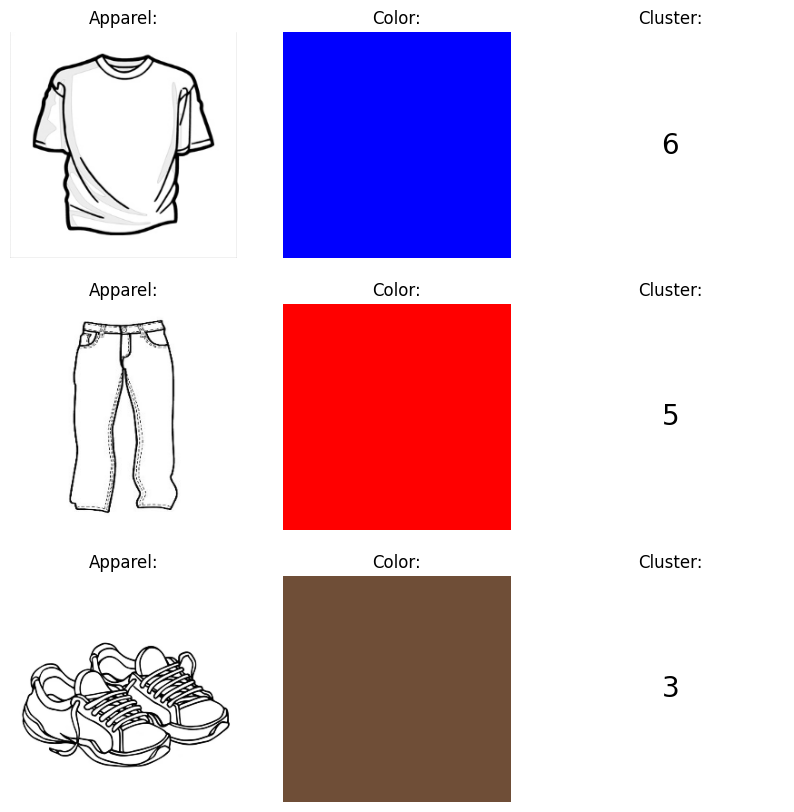

Outfit: [0 1 7 1 5 8 5 4 2], Reward: 11


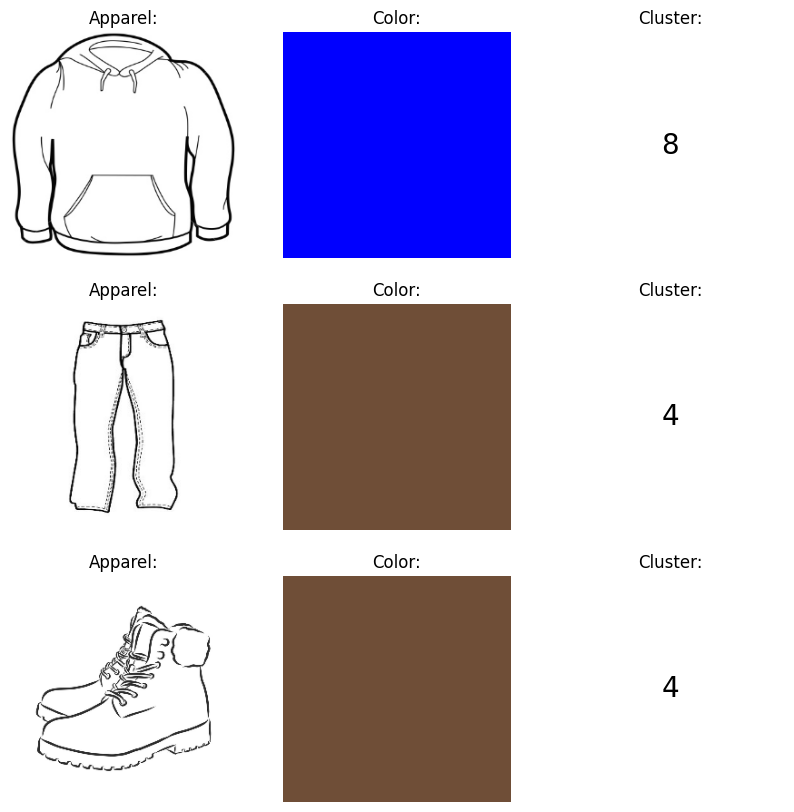

Outfit: [2 1 9 1 8 8 7 3 3], Reward: 11


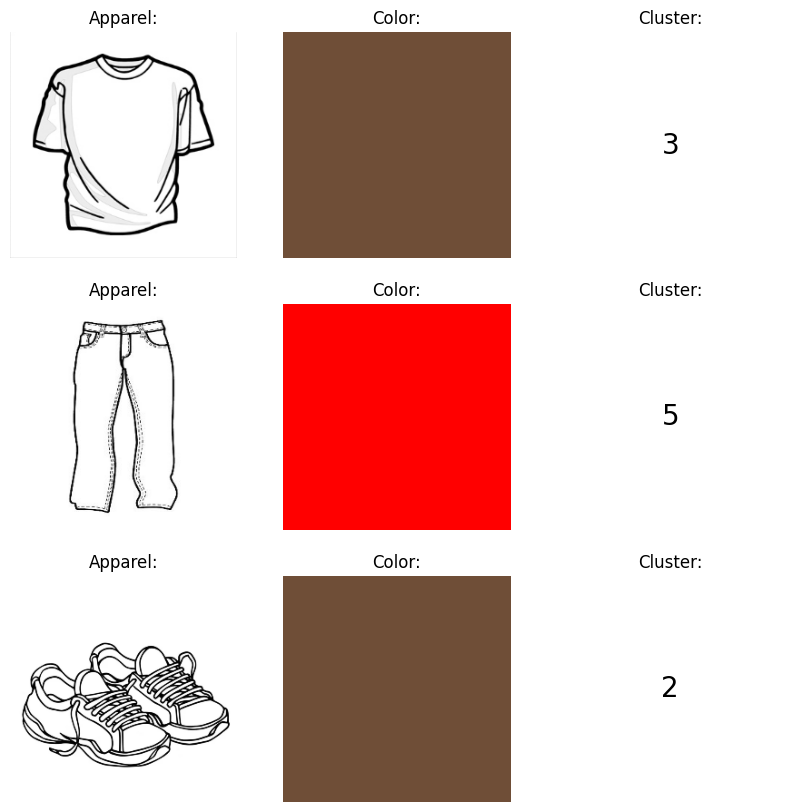

Outfit: [0 1 7 8 5 8 2 4 1], Reward: -1


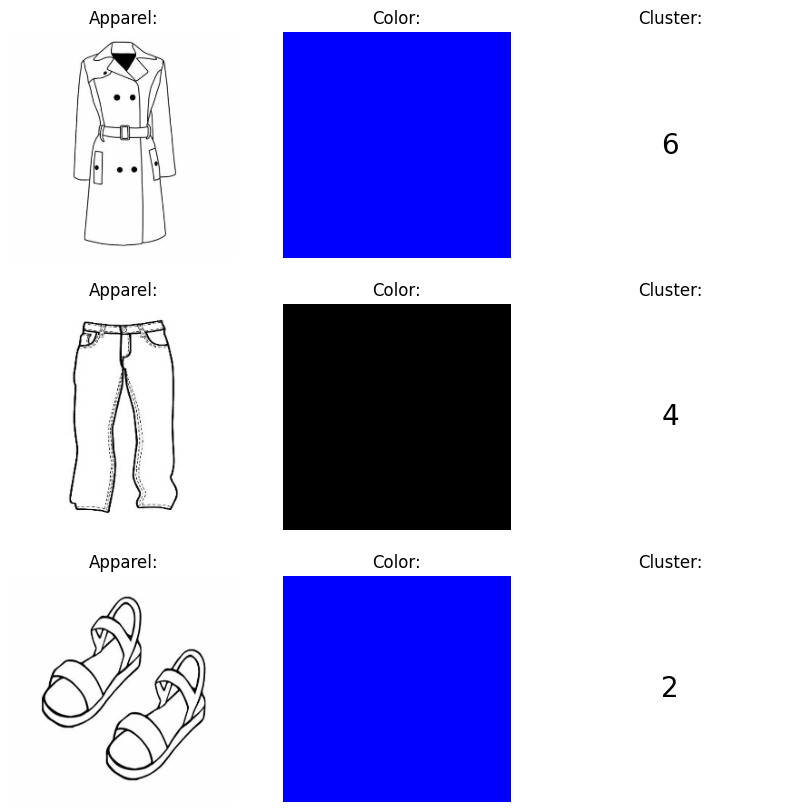

Outfit: [4 1 5 1 0 1 5 3 1], Reward: 11


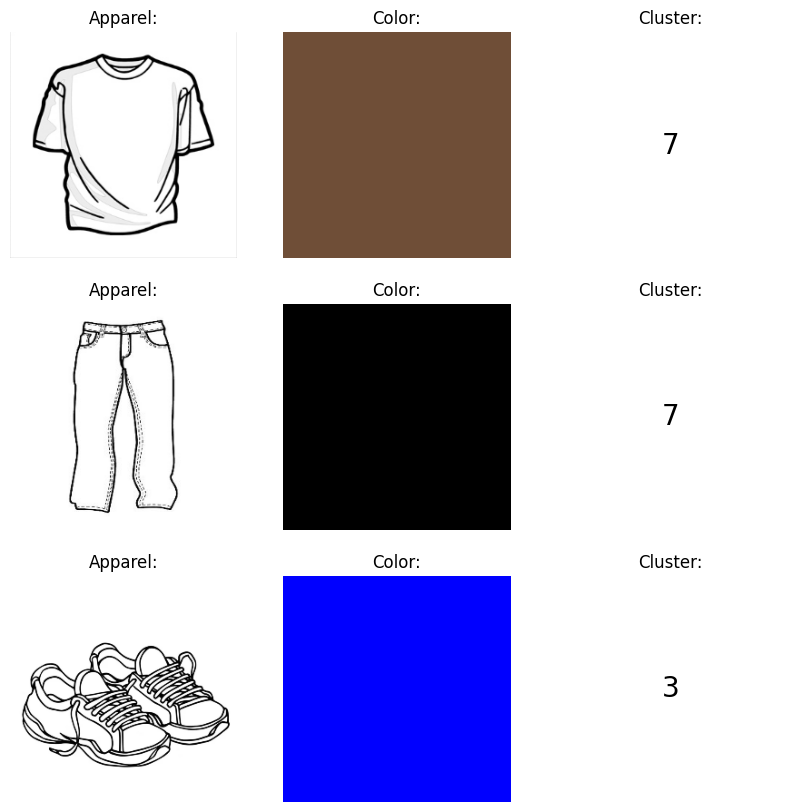

Outfit: [0 1 7 8 0 1 6 6 2], Reward: 11


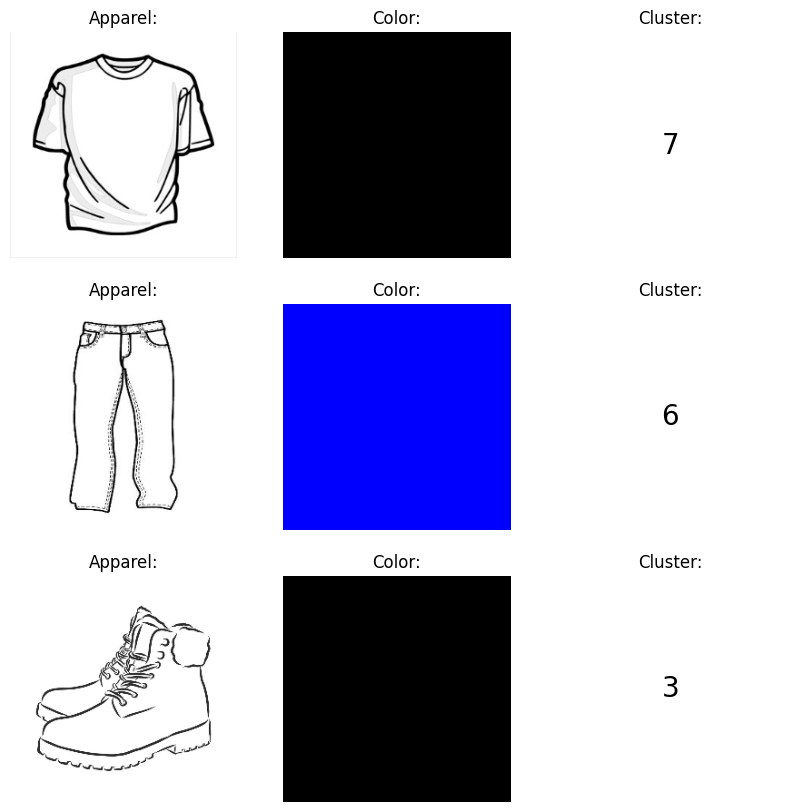

Outfit: [0 1 9 0 1 0 6 5 2], Reward: -2


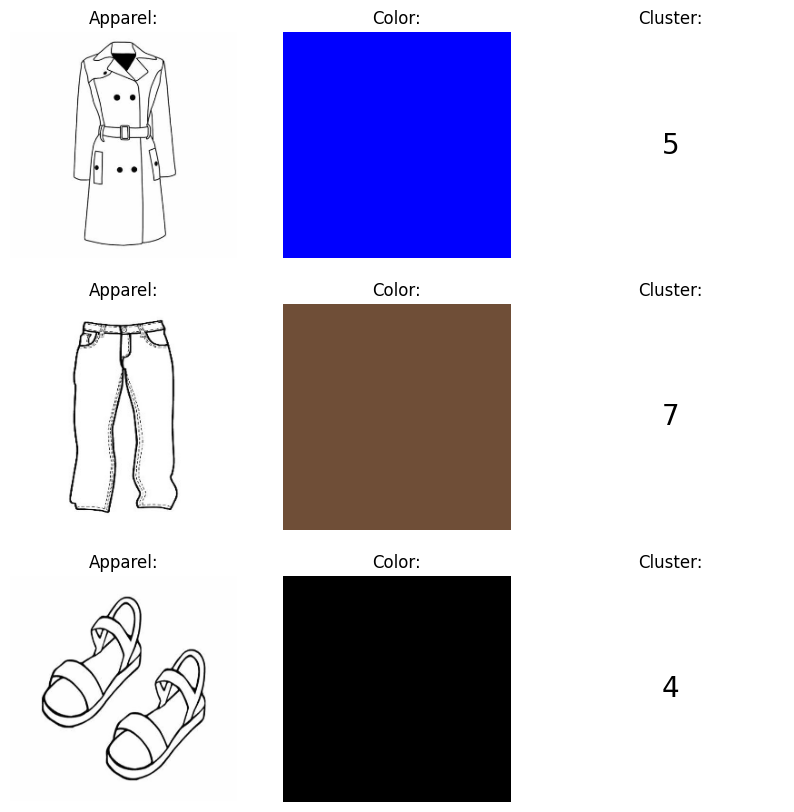

Outfit: [4 1 5 1 8 0 4 6 3], Reward: 11


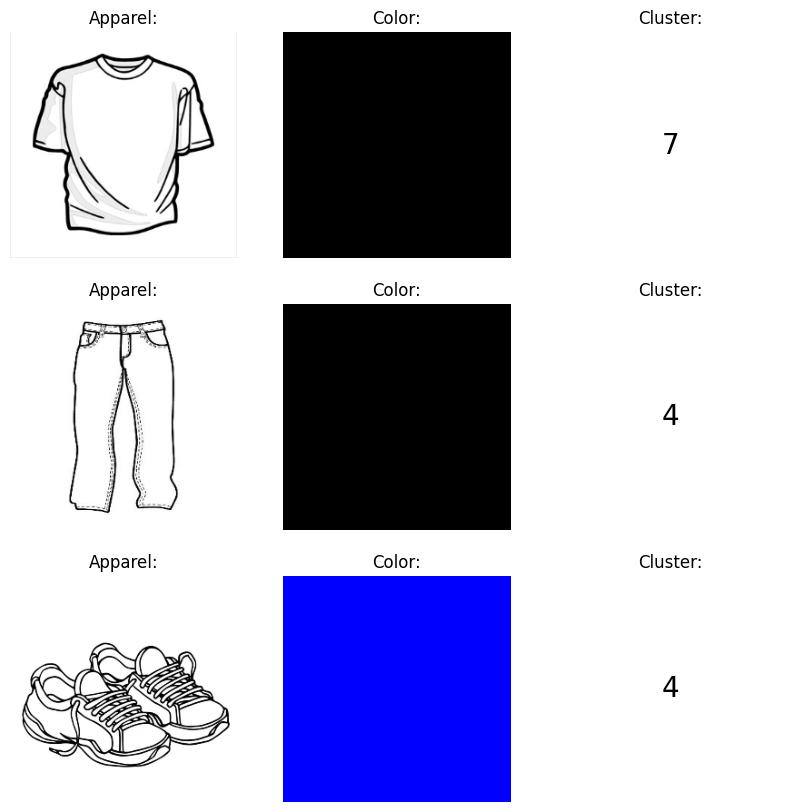

Outfit: [0 1 7 0 0 1 6 3 3], Reward: 11


In [ ]:
for _ in range(20):
    obs = env.reset()
    done = False

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)

        # Comment out the following line if rendering is slowing down your loop
        env.render(action)

        print(f"Outfit: {action}, Reward: {reward}")

# Comment out the following line if you want to keep the environment open for analysis
env.close()

In [ ]:
from google.colab import files
model.save("reinforcement_learning_0.h5")
files.download("reinforcement_learning_0.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>